# Seminar 1.  Анализ EEG 


**План**
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/maryjis/EEG_seminar/blob/main/seminar1_working_with_eeg_ipynb_.ipynb)



1. Научиться читать и предобработать данные ЭЭГ
2. Использовать Анализ независимых компонент для очищения зашумленных данных 
3. Научиться рассчитывать ERP (потенциал,связанный с событием)
4. Построить топографическое картирование активности головного мозга для ERP
5. Расчитать envelopes для бета ритма для ERP
6. Рассчитать когерентность
7. hw

In [2]:
# For Colab only
!pip install mne

In [3]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [4]:
%matplotlib notebook

mne.io поддерживает загрузку EEG данных в различных форматах

Примеры форматов (EDF, FIFF)

In [5]:
!wget "https://www.physionet.org/files/eegmmidb/1.0.0/S003/S003R03.edf"

/bin/bash: wget: command not found


In [6]:
!wget "https://www.physionet.org/files/eegmmidb/1.0.0/S003/S003R03.edf.event"

/bin/bash: wget: command not found


In [7]:
!ls

S003R03.edf                            hw1-baseline.ipynb
S003R03.edf.event                      seminar1_working_with_eeg_ipynb_.ipynb


In [8]:
sample = mne.io.read_raw_edf('S003R03.edf', verbose=False, preload=True)

Посмотрим какая есть информация о записи ЭЭГ 

In [9]:
sample.info

<Info | 7 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>

In [10]:
# Sampling frequency (Частата семплирования)
sample.info['sfreq']

160.0

In [11]:
# Length in seconds ( Длина в секундах)
len(sample) / sample.info['sfreq']

125.0

In [12]:
# Number of channels (Количество каналов)
len(sample.ch_names)

64

## Выделние каналов и добавление монтажа

In [13]:
sample.ch_names[:3]

['Fc5.', 'Fc3.', 'Fc1.']

In [14]:
sample.ch_names


['Fc5.',
 'Fc3.',
 'Fc1.',
 'Fcz.',
 'Fc2.',
 'Fc4.',
 'Fc6.',
 'C5..',
 'C3..',
 'C1..',
 'Cz..',
 'C2..',
 'C4..',
 'C6..',
 'Cp5.',
 'Cp3.',
 'Cp1.',
 'Cpz.',
 'Cp2.',
 'Cp4.',
 'Cp6.',
 'Fp1.',
 'Fpz.',
 'Fp2.',
 'Af7.',
 'Af3.',
 'Afz.',
 'Af4.',
 'Af8.',
 'F7..',
 'F5..',
 'F3..',
 'F1..',
 'Fz..',
 'F2..',
 'F4..',
 'F6..',
 'F8..',
 'Ft7.',
 'Ft8.',
 'T7..',
 'T8..',
 'T9..',
 'T10.',
 'Tp7.',
 'Tp8.',
 'P7..',
 'P5..',
 'P3..',
 'P1..',
 'Pz..',
 'P2..',
 'P4..',
 'P6..',
 'P8..',
 'Po7.',
 'Po3.',
 'Poz.',
 'Po4.',
 'Po8.',
 'O1..',
 'Oz..',
 'O2..',
 'Iz..']

In [15]:
# fix trailing dots in channel names
# use sample.rename_channels(map)

# YOUR CODE HERE
mne.rename_channels(sample.info,{ch_name: ch_name.replace(".", "") for ch_name in sample.ch_names})

In [16]:
sample.ch_names[:3]

['Fc5', 'Fc3', 'Fc1']

In [17]:
# 19 channels from 10-20. no A1 and A2 here
# Be careful. Pure 10-20 labeling differs from high-resolution montages
# In MNE, 10-20 montage is actually an extended high-resulution version of 10-20
# FYI, mapping from pure 10-20 to high-resolution versions
# T3 = T7
# T4 = T8
# T5 = P7
# T6 = P8

channels_to_use = [
    # prefrontal
    'Fp1',
    'Fp2',
    # frontal
    'F7',
    'F3',
    'F4',
    'Fz',
    'F8',
    # central and temporal
    'T7',
    'C3',
    'Cz',
    'C4',
    'T8',
    # parietal
    'P7',
    'P3',
    'Pz',
    'P4',
    'P8',
    # occipital
    'O1',
    'O2',
]

In [18]:
sample_1020 = sample.copy().pick_channels(channels_to_use)

# check that everything is OK
assert len(channels_to_use) == len(sample_1020.ch_names)

In [19]:
ch_map = {ch.lower(): ch for ch in sample_1020.ch_names}

In [20]:
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
len(ten_twenty_montage.ch_names)

94

In [21]:
ten_twenty_montage.ch_names = [ch_map[ch.lower()] if ch.lower() in ch_map else ch 
                               for ch in ten_twenty_montage.ch_names]

In [22]:
sample_1020.set_montage(ten_twenty_montage)

<RawEDF | S003R03.edf, 19 x 20000 (125.0 s), ~2.9 MB, data loaded>

<IPython.core.display.Javascript object>


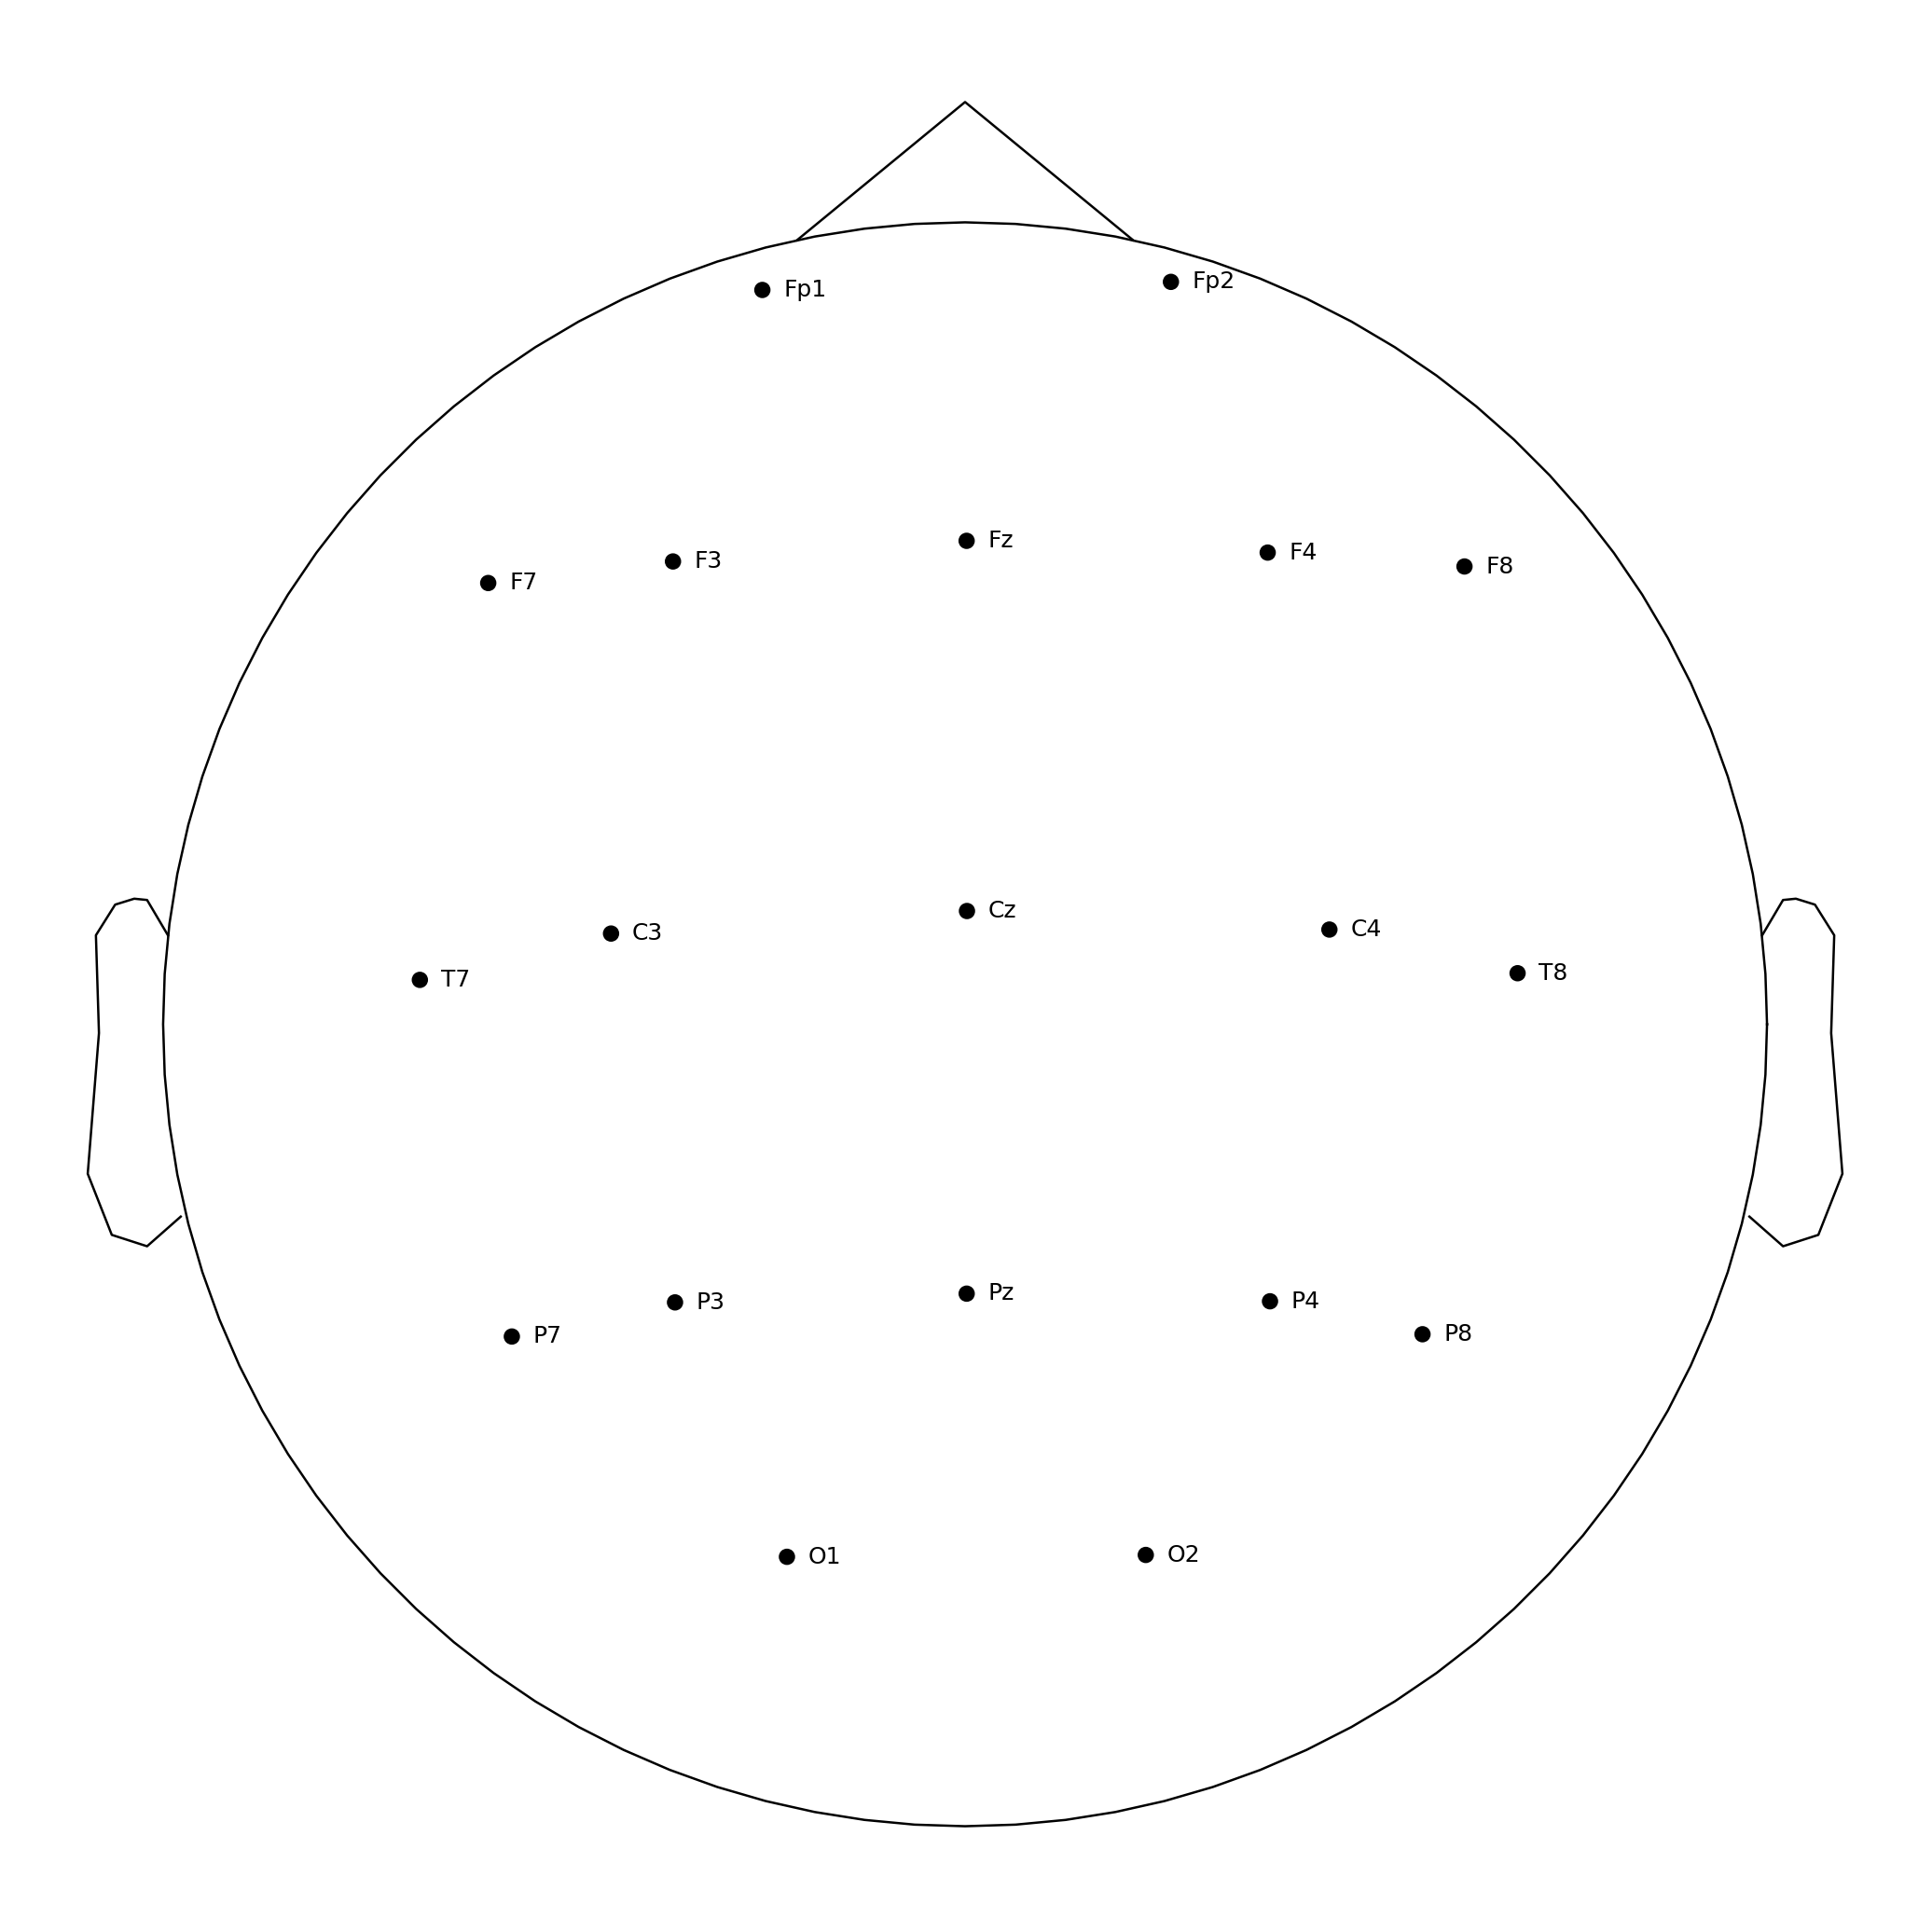

<IPython.core.display.Javascript object>


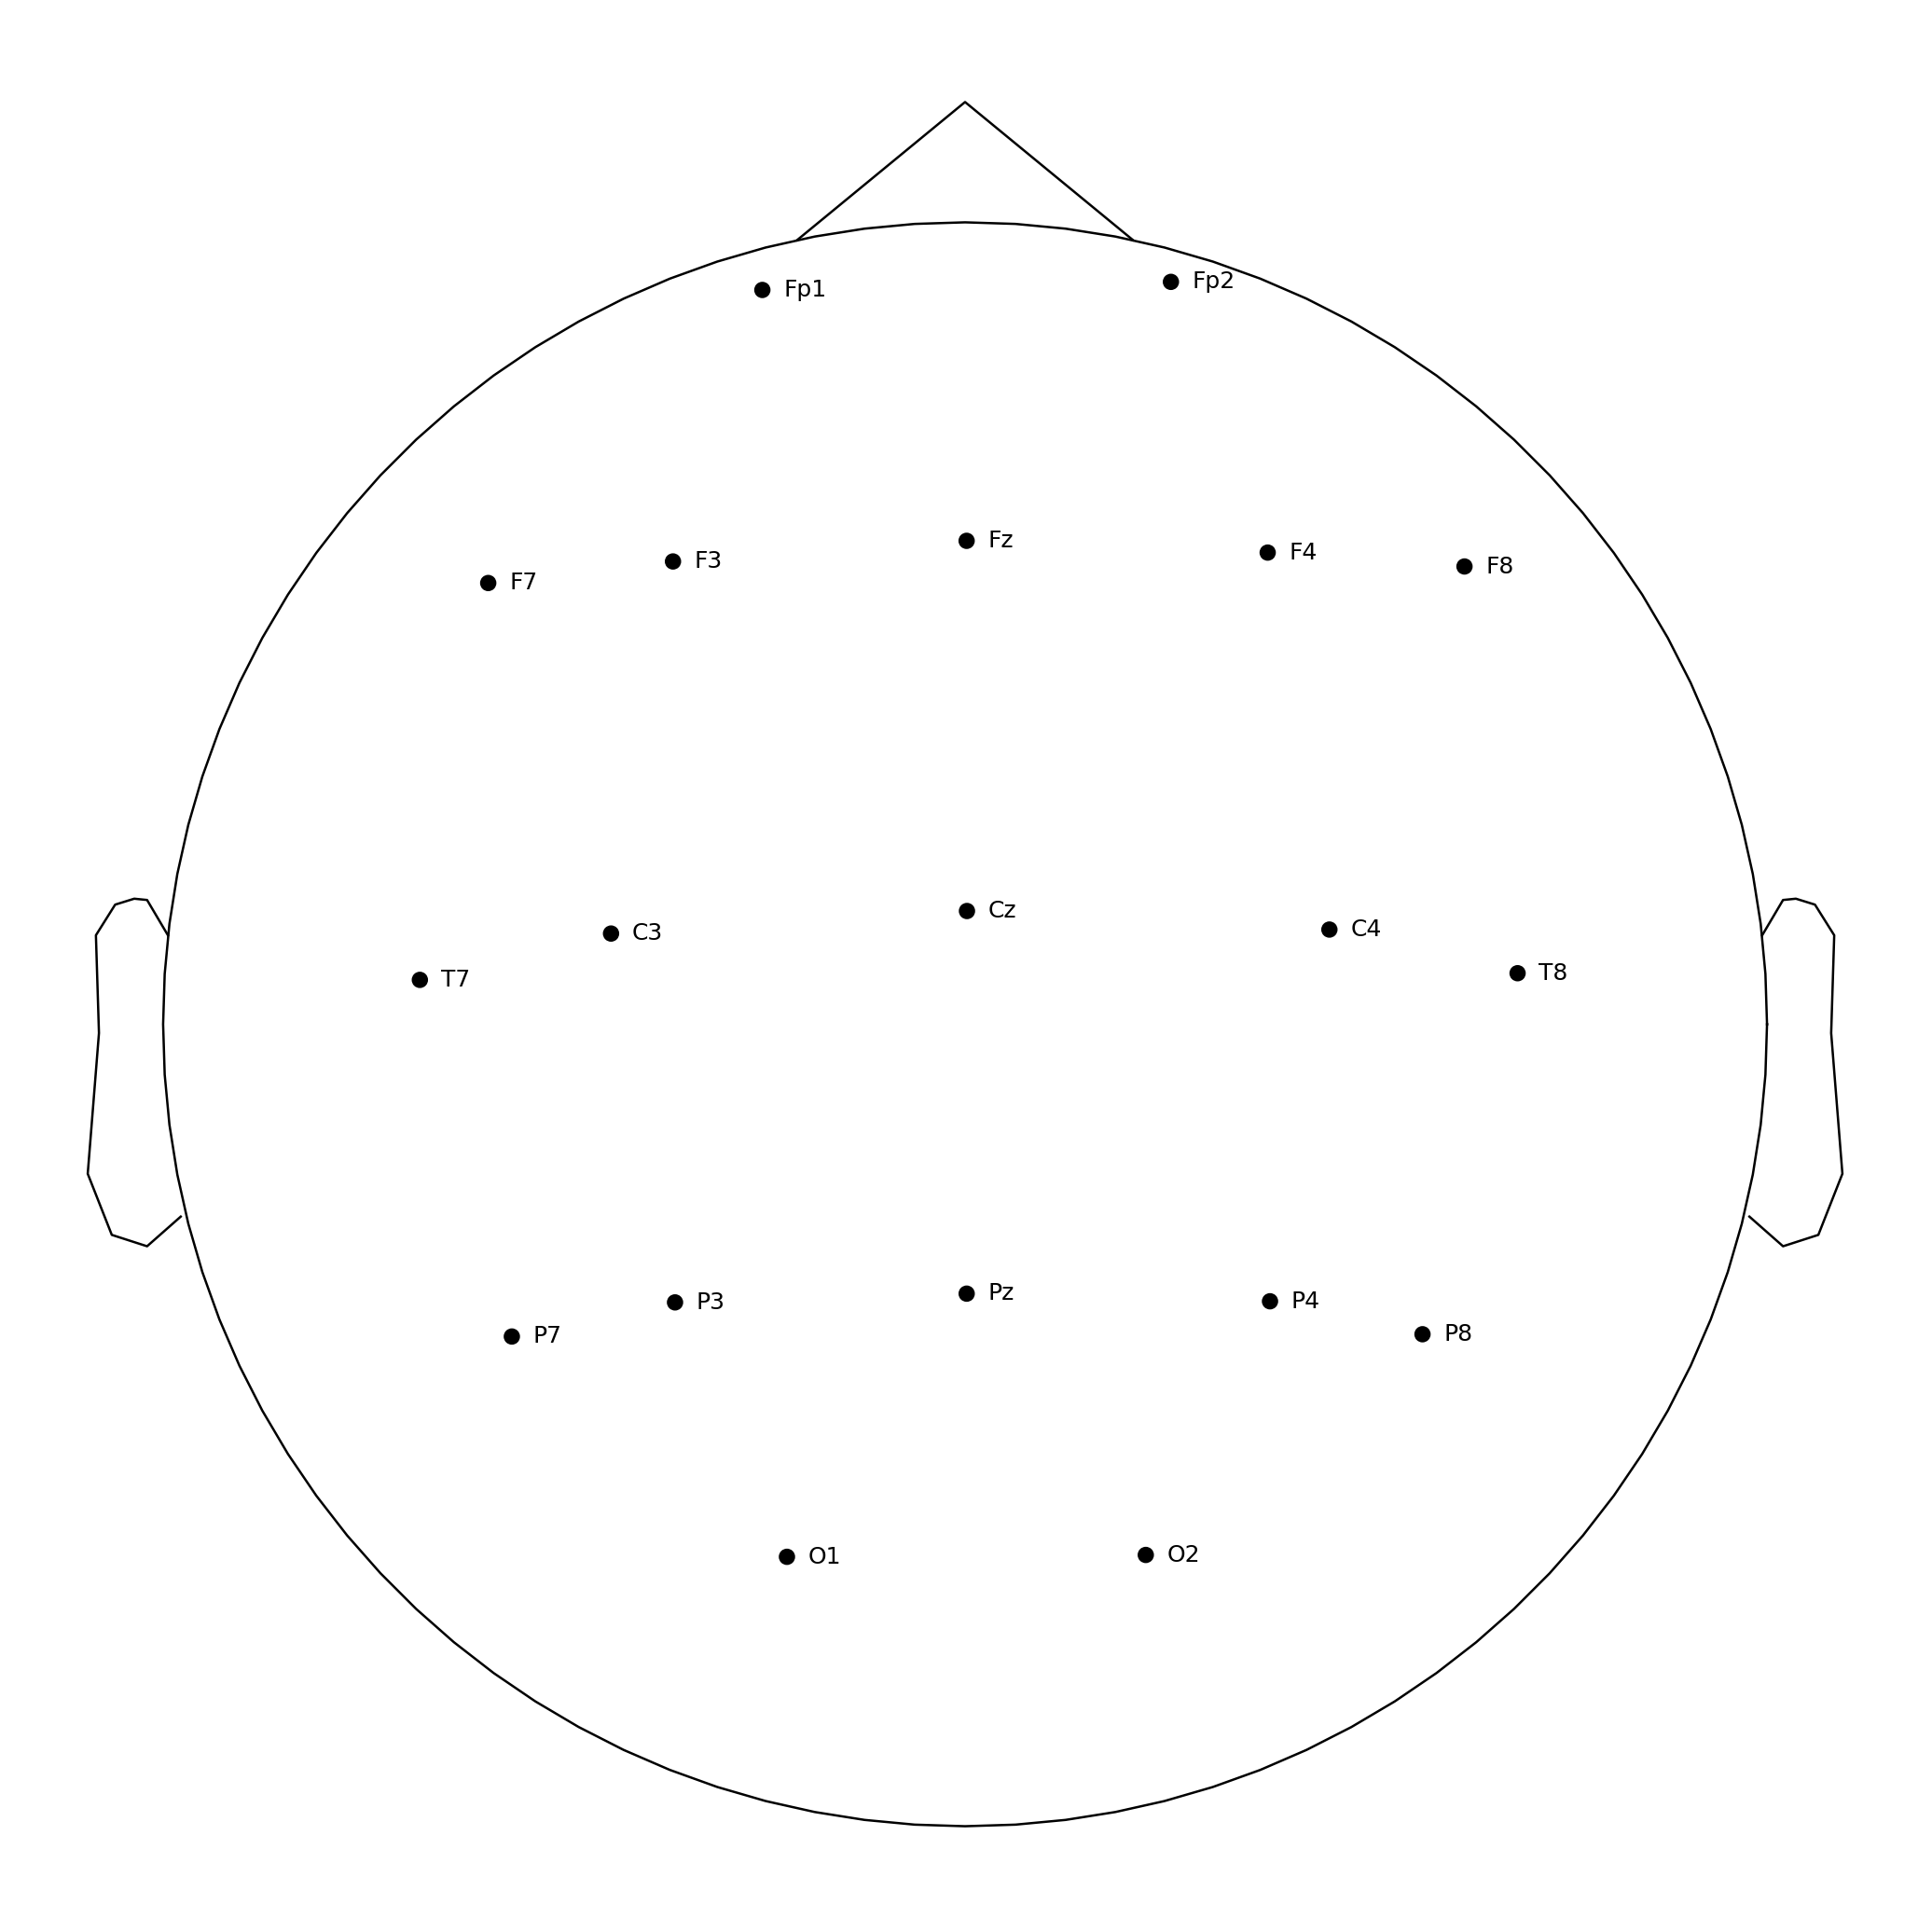

In [23]:
sample_1020.plot_sensors(show_names=True)

## Исследуем сигнал

Спектральную плоность мощности сигнала (PSD) - функция, описывающая распределение мощности сигнала от его частоты:

$$P =\lim_{T \to +\infty} \frac{1}{T}\int_{\infty}^{-\infty}|x^2(t)|dt $$




$$S(w) =\lim_{T \to +\infty} \frac{|F_T(w)|^2}{T} = \int_{\infty}^{-\infty} R_{xx}(\tau)e^{-i2\pi\tau}d\tau $$


$R_{xx}$ - функция автокореляции 


$F_T(w)$ - Фурье преобразование 

<IPython.core.display.Javascript object>


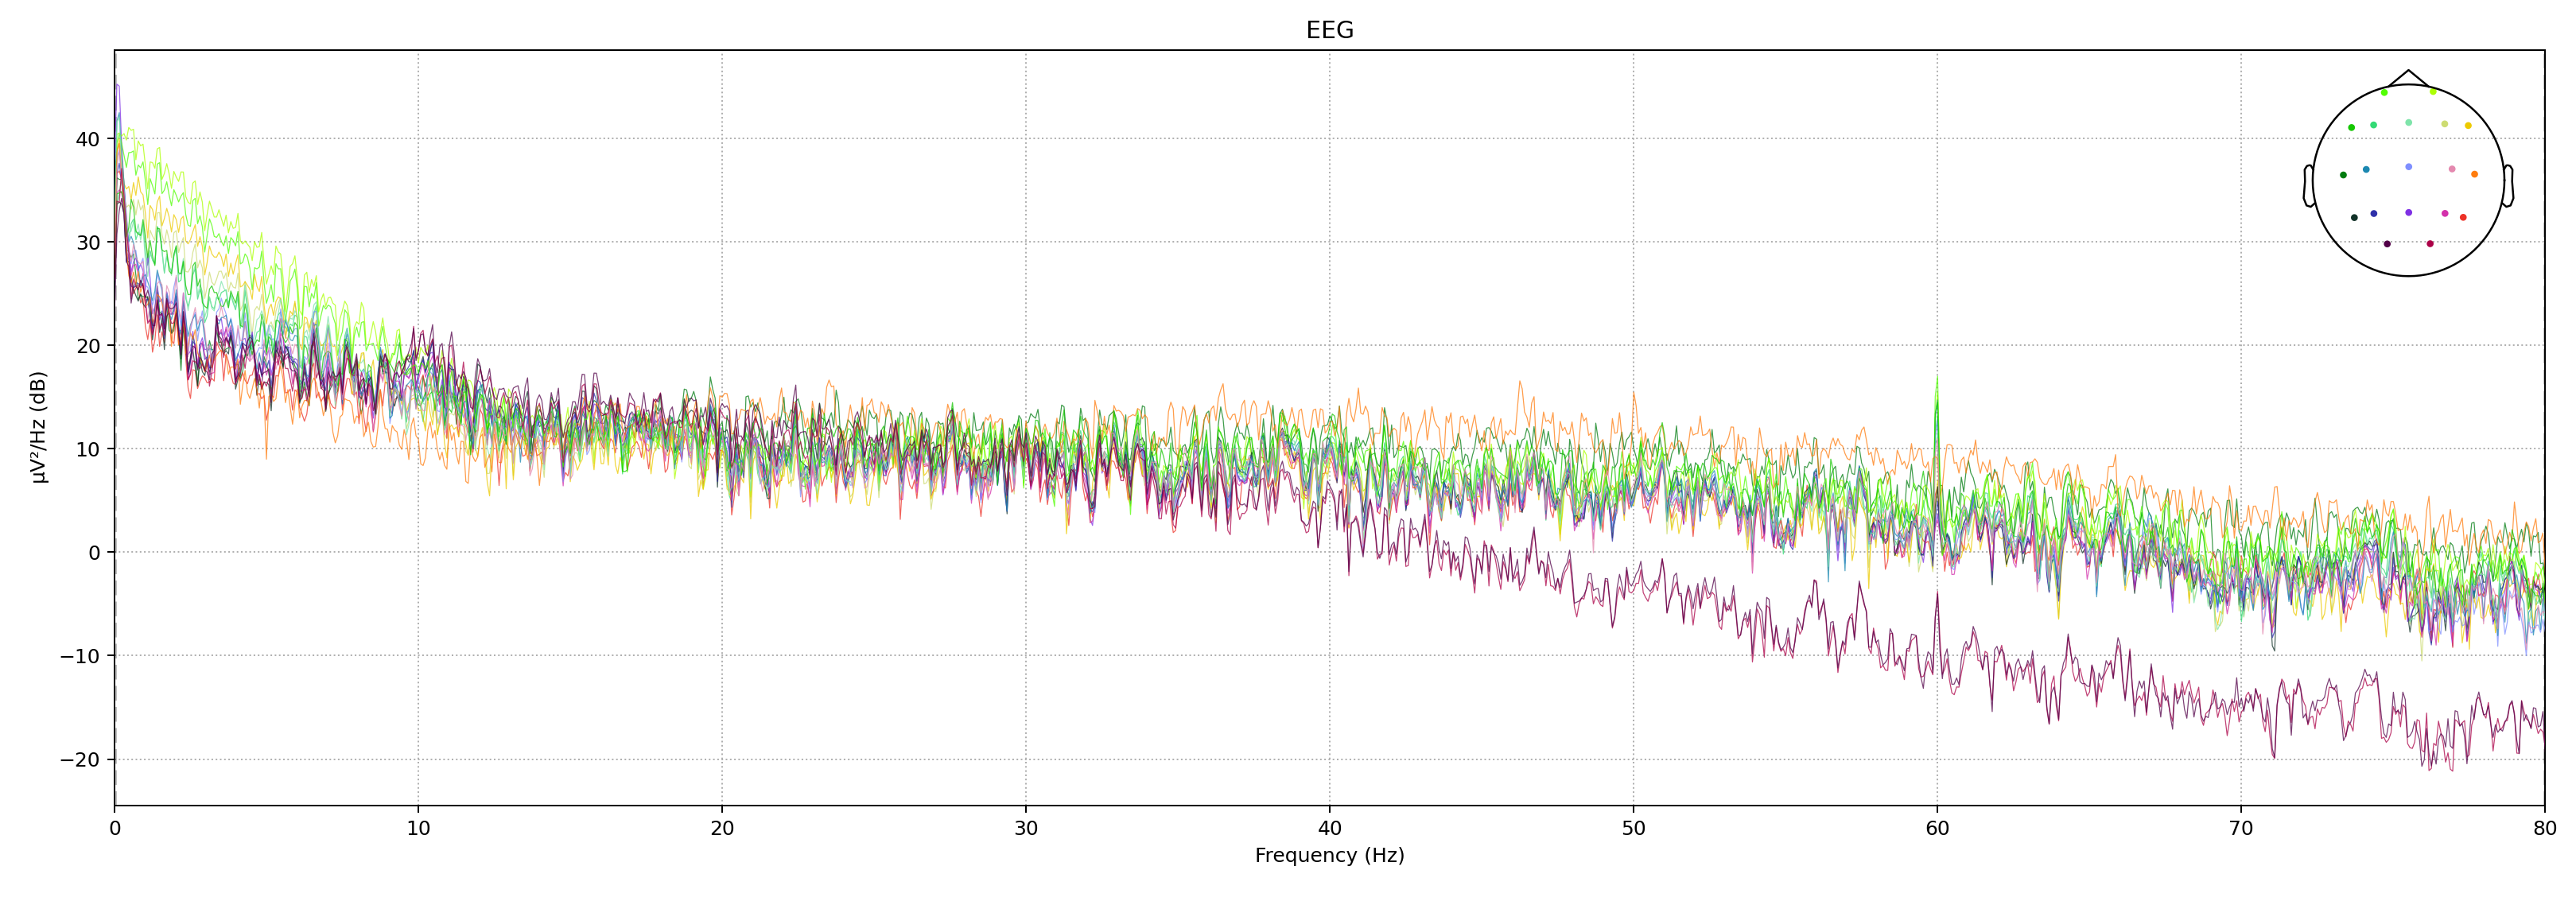

In [24]:
sample_1020.plot_psd();

### Band-pass filtering

Удалим низкие и высокие частоты < 1 Hz and high-freq > 50Hz (неинформативно для EEG)

Используем фильтр Баттерво́рта (default IIR filter)

In [25]:
sample_1020.filter(l_freq=1, h_freq=50, method='iir')

<RawEDF | S003R03.edf, 19 x 20000 (125.0 s), ~2.9 MB, data loaded>

In [26]:
# Plot psd after filtering

# YOUR CODE HERE


### Plot EEG signals

In [27]:
sample_1020.plot(n_channels=8, duration=20);

Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>

In [28]:
# Plot in better scale. Use 'scaling' argument

# YOUR CODE HERE
sample_1020.plot(n_channels=8, duration=20, scalings='auto');

<IPython.core.display.Javascript object>

In [29]:
?sample_1020.plot

## Извлечение событий

Mne  

* `mne.find_events` используется когда события хранятся в отдельном канале (e.g. FIFF format)
* `mne.events_from_annotations` используется когда события хранятся отдельно в аннотациях (EDF+ format)
    
Посмотрите на документацию в EEG-record формате

У нас здесь представлено в EDF+ формате

In [30]:
events, events_dict = mne.events_from_annotations(sample_1020)

Used Annotations descriptions: ['T0', 'T1', 'T2']


In [31]:
len(sample_1020)

20000

In [32]:
events_dict

{'T0': 1, 'T1': 2, 'T2': 3}

In [33]:
events[:5]

array([[   0,    0,    1],
       [ 672,    0,    3],
       [1328,    0,    1],
       [2000,    0,    2],
       [2656,    0,    1]])

In [34]:
epochs = mne.Epochs(sample_1020, events,  tmin=-0.5, tmax=0.8, preload=True)

Not setting metadata
Not setting metadata
30 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 30 events and 209 original time points ...
1 bad epochs dropped


In [35]:
pd.DataFrame(epochs.events, columns=['_', '__', 'event_id'])['event_id'].value_counts()

1    14
3     8
2     7
Name: event_id, dtype: int64

Check that length is right

In [36]:
for epoch in epochs:
    break
epoch.shape

(19, 209)

In [37]:
epoch.shape[1] / sample_1020.info['sfreq']

1.30625

In [38]:
sample_1020.to_data_frame().shape

(20000, 20)

In [39]:
df = epochs.to_data_frame()
df.head(3).iloc[:, :10]

,time,condition,epoch,C3,Cz,C4,Fp1,Fp2,F7,F3
0,-500,3,1,-4.547919,-1.344287,1.476721,236.675891,244.275703,125.936913,88.829681
1,-494,3,1,-4.844281,-12.002902,3.515891,175.970007,183.425016,103.803572,63.009365
2,-488,3,1,-2.909761,-11.900140,6.341468,127.095181,132.985975,61.669835,31.478465


In [40]:
df[sample_1020.ch_names + ['epoch']].groupby('epoch').agg(lambda arr: arr.max() - arr.min())

,C3,Cz,C4,Fp1,Fp2,F7,F3,Fz,F4,F8,T7,T8,P7,P3,Pz,P4,P8,O1,O2
epoch,,,,,,,,,,,,,,,,,,,
1,254.596639,255.881668,224.855441,333.406929,365.528247,212.744342,214.208704,245.580869,219.835898,220.063865,253.916327,235.180057,254.091421,260.386276,242.255995,232.244254,177.886985,273.820144,249.366403
2,144.064301,161.207735,160.031445,162.662465,142.537847,126.436374,142.165568,161.170045,123.814032,124.934782,168.377000,166.180220,173.546095,163.896960,164.407775,155.929620,130.665825,170.546430,155.284275
3,142.598417,178.721440,192.486160,155.598308,149.890004,169.550381,195.284681,195.993715,172.320451,120.277482,144.163639,175.350945,167.742599,166.698477,165.797935,155.386226,131.897224,194.149074,178.298001
4,154.277876,149.533817,129.960369,443.527711,568.537177,279.712376,249.209658,204.306910,249.261709,320.889577,178.938867,172.664972,172.554785,158.571001,170.920383,138.034229,107.992717,193.324495,171.951761
5,176.950188,194.398317,183.134891,156.831325,160.882198,165.676600,179.189667,191.831481,159.741210,150.080110,163.359478,179.399369,192.812573,182.333115,183.454255,162.776560,139.734206,205.524671,173.114832
6,206.149723,207.556487,196.952631,698.845587,818.741700,356.828849,322.565743,315.285146,400.871426,496.445397,232.199548,228.019286,204.560182,197.875668,195.840205,179.078439,163.823732,198.260504,197.548144
7,247.888086,253.478886,215.805862,542.278455,675.759762,297.380917,262.005933,257.432757,334.528394,426.592865,213.697592,168.313921,217.294293,206.639787,227.127343,189.574686,156.345053,199.731497,193.587781
8,161.395948,161.428693,168.823815,483.242896,662.757617,238.519844,226.301945,253.279895,306.918195,400.459780,185.336922,166.369459,154.739536,133.178416,127.037910,132.036981,127.052466,171.831320,175.316614
9,160.296300,180.018250,159.227600,465.768416,628.822504,257.292858,261.137098,250.298585,310.392589,360.728109,177.620977,188.059974,191.526016,176.616854,191.556302,188.012787,162.242320,199.281799,187.057417


<IPython.core.display.Javascript object>


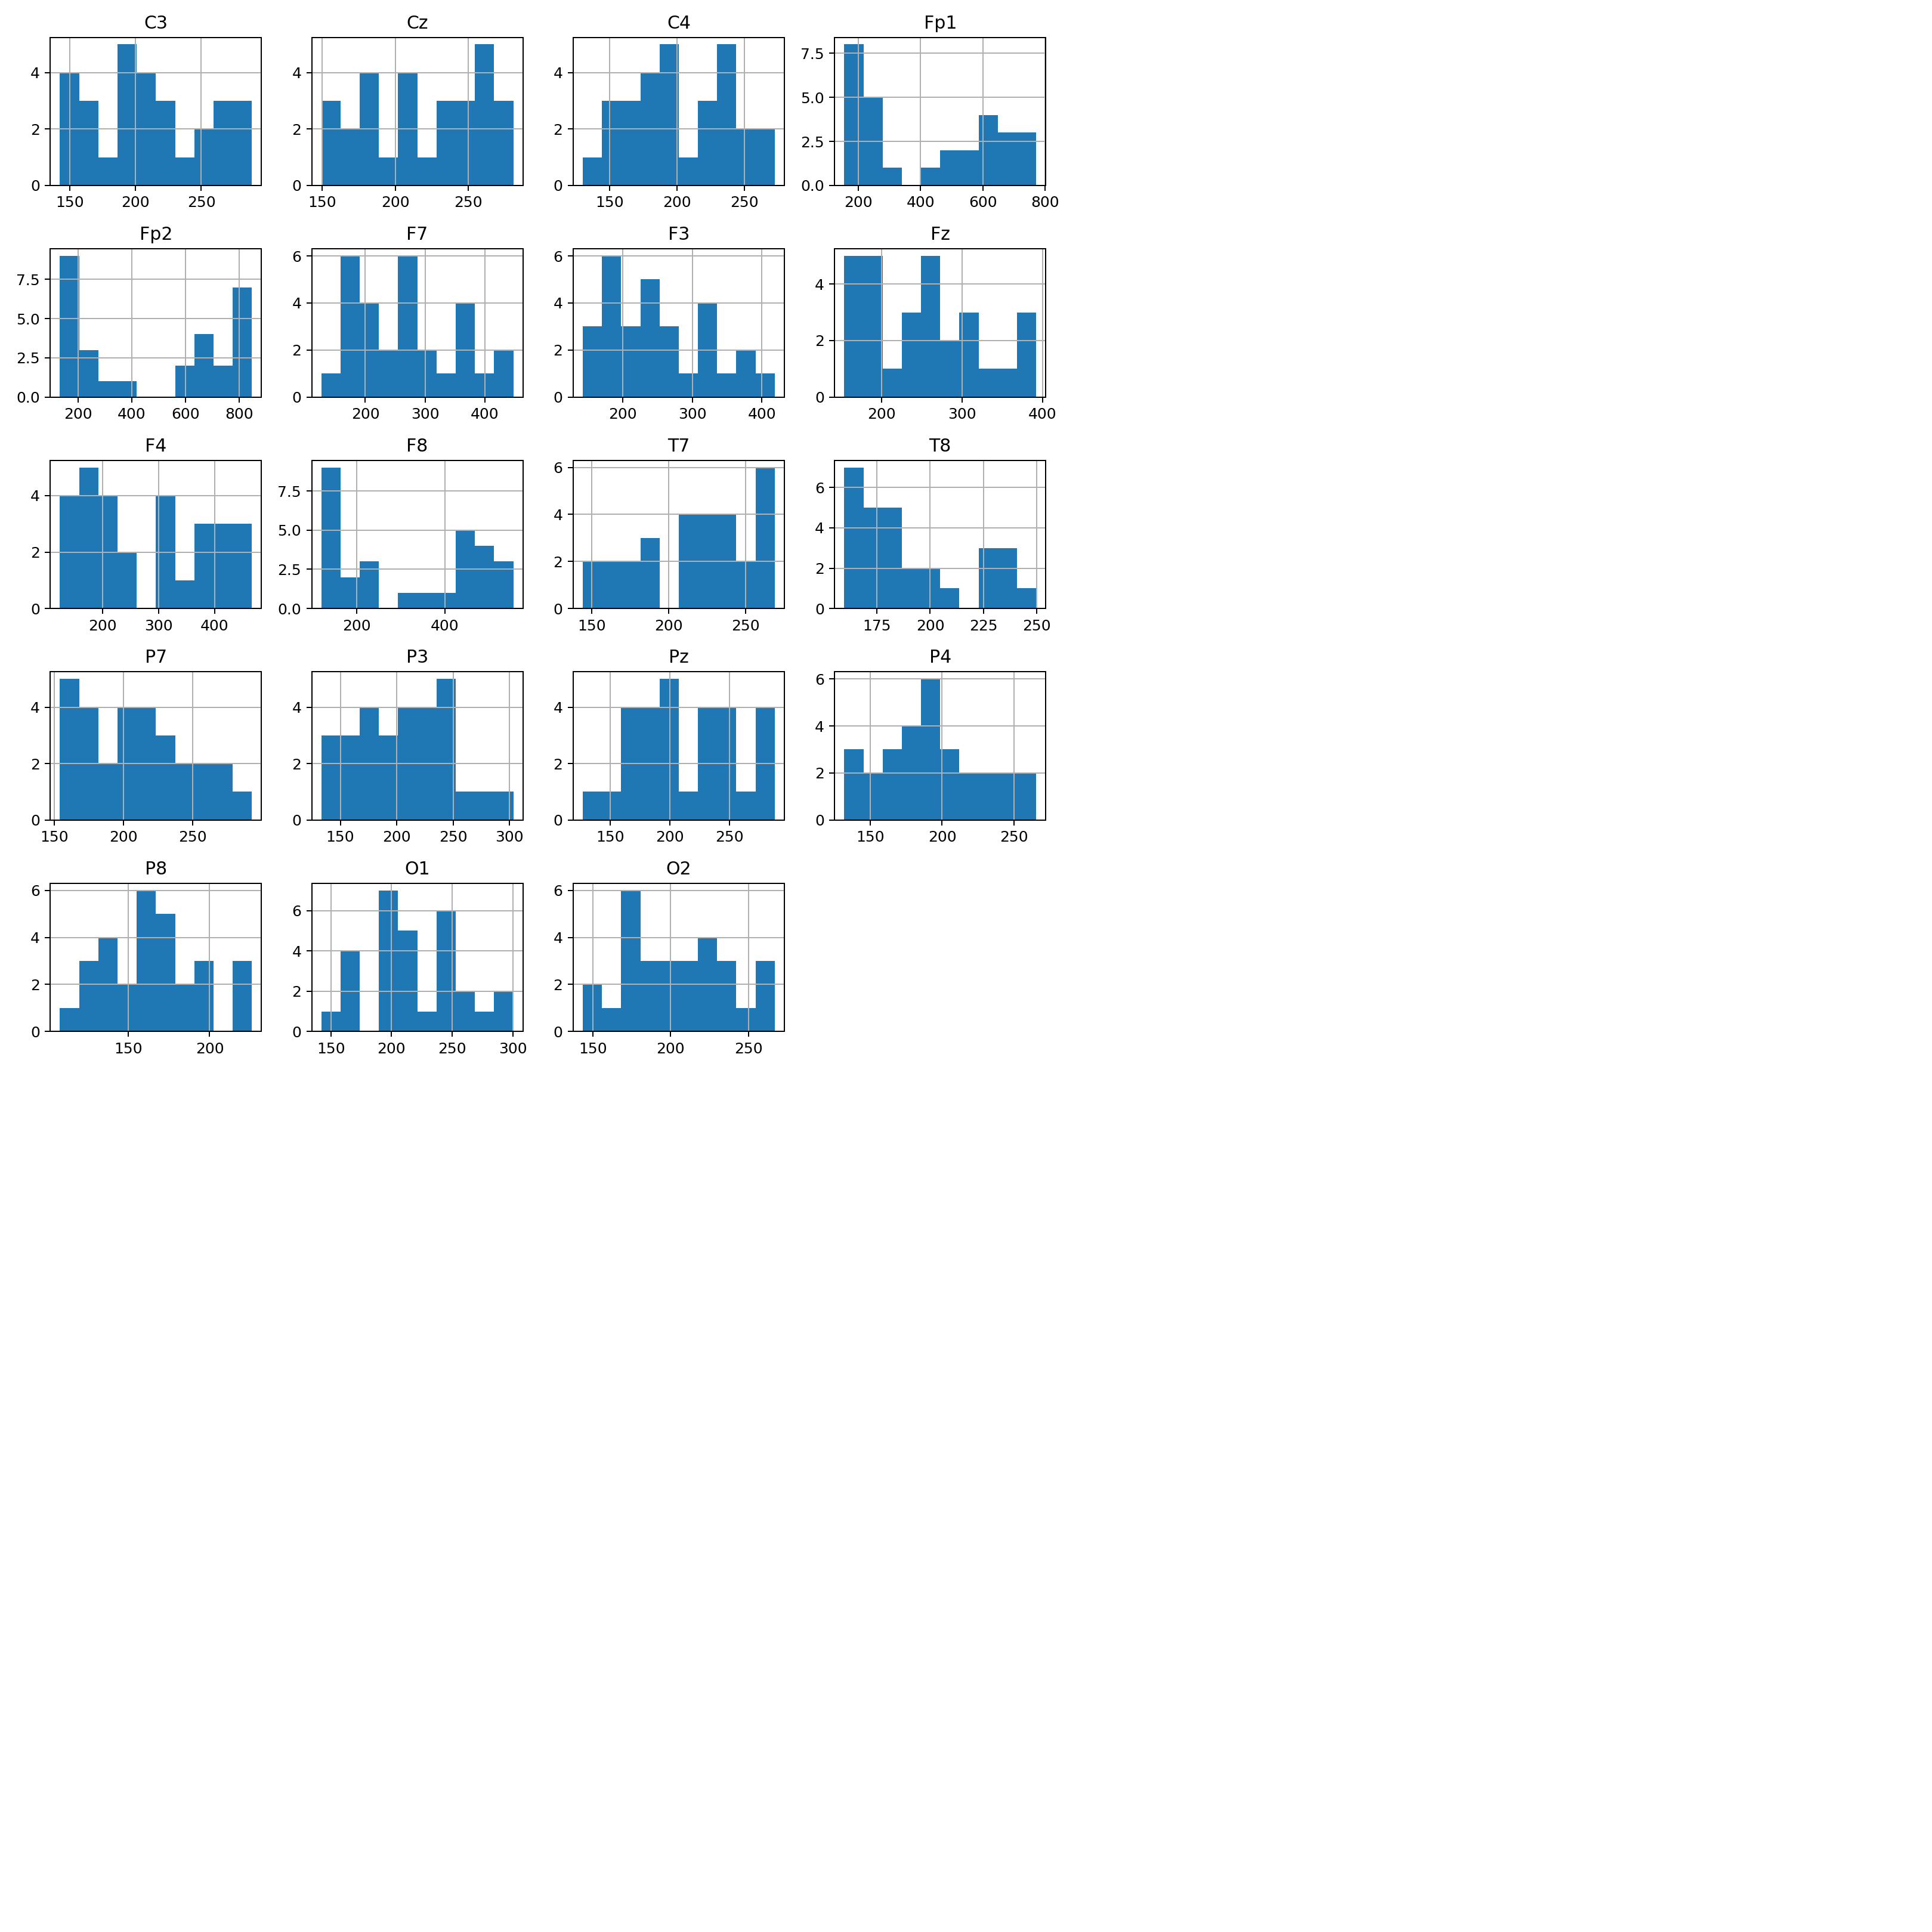

In [41]:
df[sample_1020.ch_names + ['epoch']].groupby('epoch').agg(lambda arr: arr.max() - arr.min()).hist(figsize=[10, 10]);
plt.tight_layout()

мы будем отбрасывать любую эпоху, в которой амплитуда сигнала от пика до пика выходит за разумные пределы для этого типа канала.

In [42]:
600e-6

0.0006

In [43]:
epochs = mne.Epochs(sample_1020, events,  tmin=-0.5, tmax=0.8, reject={'eeg': 600e-6}, preload=True, baseline=(-.1, 0))

Not setting metadata
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 30 events and 209 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
15 bad epochs dropped


PSD on epochs differs from the raw. More averaging is used

<IPython.core.display.Javascript object>


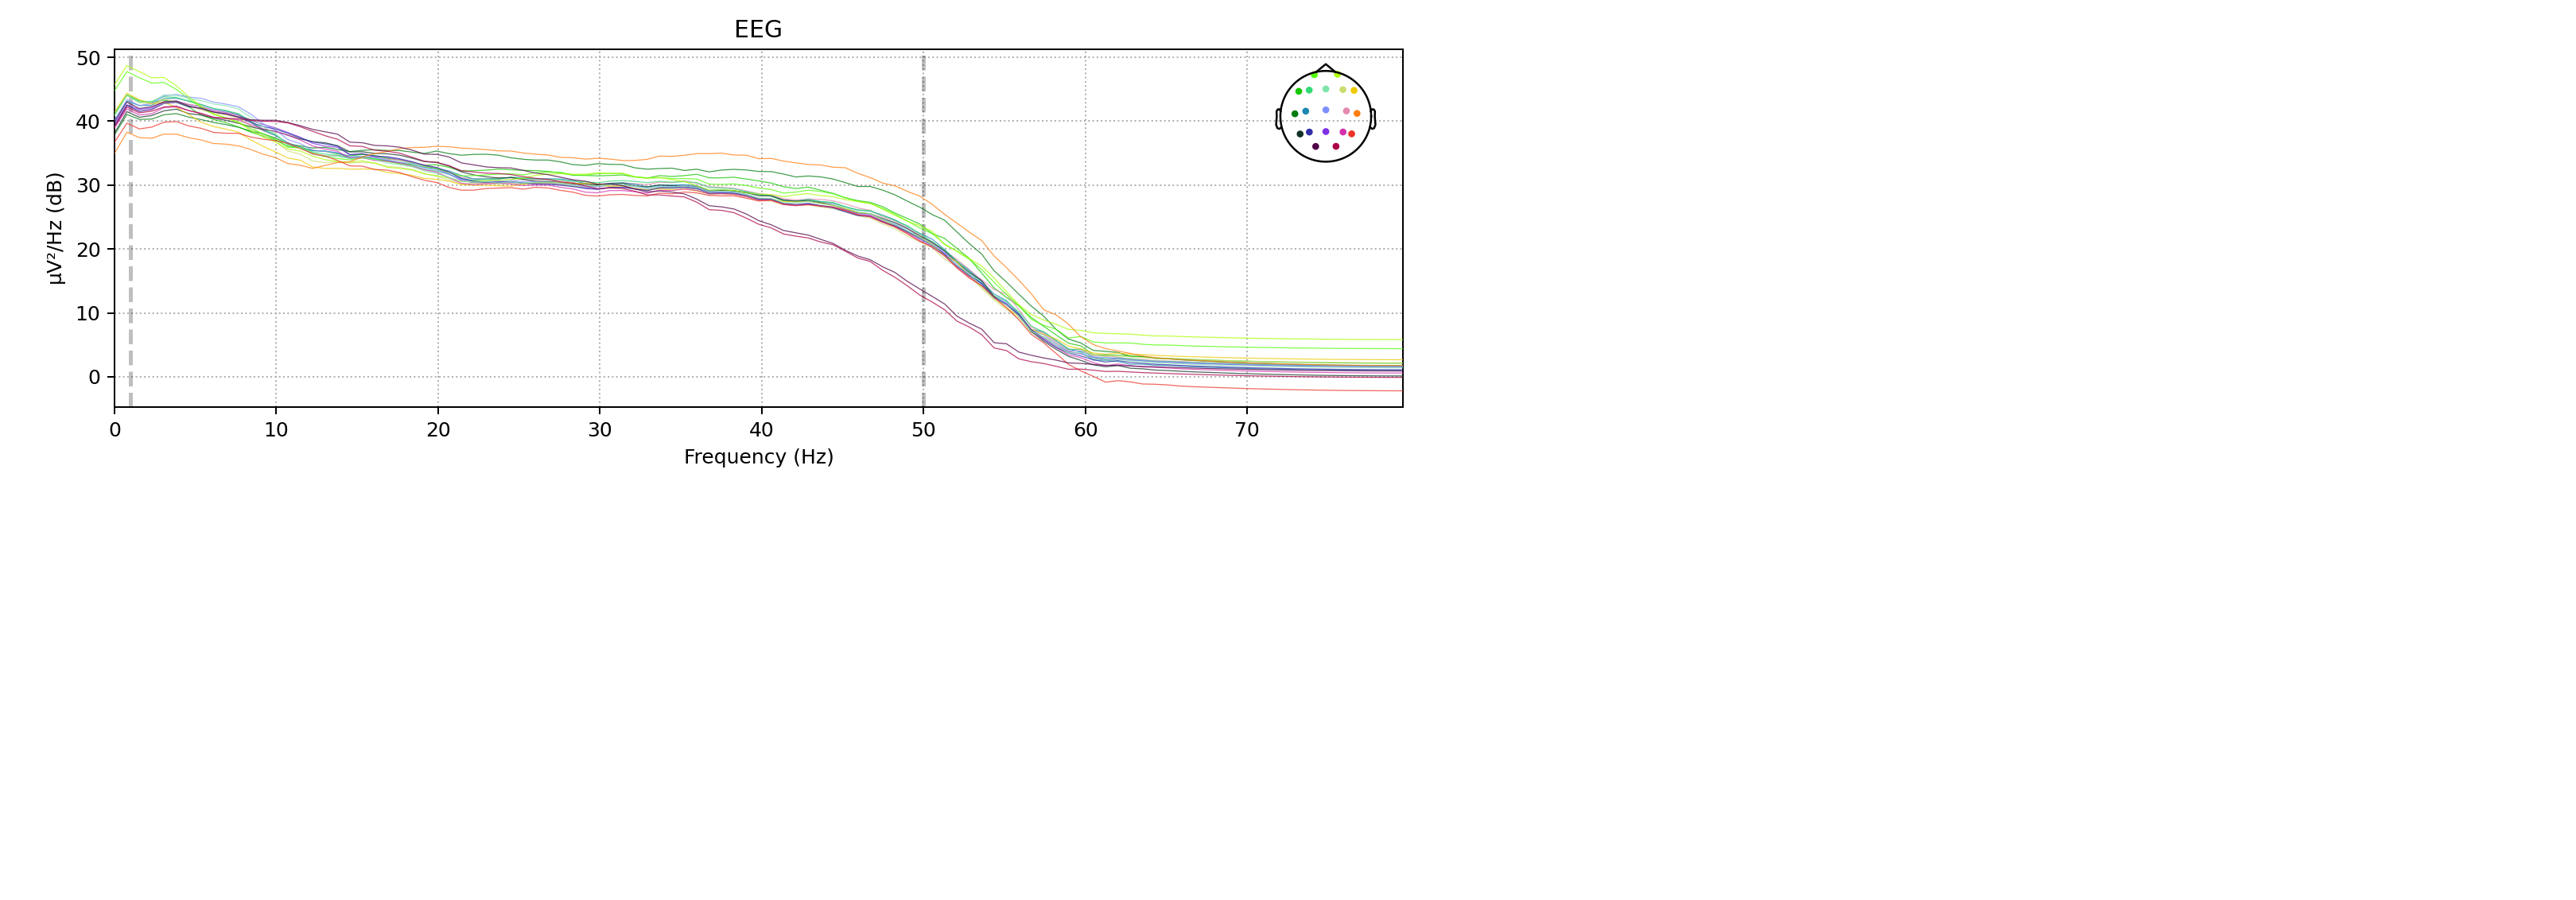

    Using multitaper spectrum estimation with 7 DPSS windows


In [44]:
epochs.plot_psd();

In [ ]:
# epochs.plot(n_channels=8, scalings={'eeg':1e-4});

In [ ]:
epochs.event_id

In [ ]:
# check number of events of each type
# use epochs.events

# Your code here

pd.DataFrame(epochs.events, columns=['_', '__', 'event_id'])['event_id'].value_counts()

In [ ]:
evoked_T0 = epochs['1'].average()
evoked_T1 = epochs['2'].average()
evoked_T2 = epochs['3'].average()

In [ ]:
evoked_T0.plot(spatial_colors=True);

In [ ]:
evoked_T1.plot(spatial_colors=True);

In [ ]:
evoked_T2.plot(spatial_colors=True);

## Independent Component Analysis for Artifact Removal

In [ ]:
ica = mne.preprocessing.ICA(n_components=10, random_state=42)

In [ ]:
ica.fit(sample_1020)

In [ ]:
ica.plot_sources(sample_1020);

In [ ]:
ica.plot_components();

Давайте изучим  ICA компоненты более глубоко. Посмотрим на спектограммы. Информация о сегментах здесь не очень актуальна, так как мы строим ICA на необработанных данных.

Мы ожидаем увидеть пики альфа- и бета-ритмов на спектрограмме для хороших компонентов (7-13 Гц и 13-30 Гц соответственно). А также небольшое снижение по мере увеличения частоты

In [ ]:
ica.plot_properties(sample_1020, picks=[1]);

In [ ]:
ica.plot_overlay(sample_1020, exclude=[0,1], picks=['F3']);

In [ ]:
ica.exclude = [0, 1]

In [ ]:
sample_1020_clr = sample_1020.copy()

In [ ]:
ica.apply(sample_1020_clr)

In [ ]:
# plot channels

# YOUR CODE HERE


In [ ]:
epochs = mne.Epochs(sample_1020_clr, events,  tmin=-0.5, tmax=0.8, reject={'eeg': 600e-6}, preload=True, baseline=(-.1, 0))


In [ ]:
evoked_T0 = epochs['1'].average()
evoked_T1 = epochs['2'].average()
evoked_T2 = epochs['3'].average()

In [ ]:
evoked_T0.plot(spatial_colors=True);

In [ ]:
evoked_T1.plot(spatial_colors=True);

In [ ]:
evoked_T2.plot(spatial_colors=True);

## Dynamics of alpha and beta activity

In [ ]:
evoked_T0_alpha = evoked_T0.copy().filter(l_freq=7, h_freq=13, method='iir', verbose=False).apply_hilbert(envelope=True)
evoked_T1_alpha = evoked_T1.copy().filter(l_freq=7, h_freq=13, method='iir', verbose=False).apply_hilbert(envelope=True)
evoked_T2_alpha = evoked_T2.copy().filter(l_freq=7, h_freq=13, method='iir', verbose=False).apply_hilbert(envelope=True)


In [ ]:
evoked_T1_alpha.plot(spatial_colors=True);

In [ ]:
evoked_T2_alpha.plot(spatial_colors=True);

In [ ]:
evoked_T0_beta_low = evoked_T0.copy().filter(l_freq=13, h_freq=20, method='iir', verbose=False).apply_hilbert(envelope=True)
evoked_T1_beta_low = evoked_T1.copy().filter(l_freq=13, h_freq=20, method='iir', verbose=False).apply_hilbert(envelope=True)
evoked_T2_beta_low = evoked_T2.copy().filter(l_freq=13, h_freq=20, method='iir', verbose=False).apply_hilbert(envelope=True)


In [ ]:
evoked_T0_beta_low

In [ ]:
evoked_T2_alpha.plot(spatial_colors=True);

##  Посчитаем функциональную коннективность

In [ ]:
conn_T1, freqs, times, _, _ = mne.connectivity.spectral_connectivity(epochs['2'], method='coh')

In [ ]:
def plot_topomap_connectivity_2d(info, con, picks=None, pairs=None, vmin=None, vmax=None, cm=None, show_values=False, show_names=True):
    """
    Plots connectivity-like data in 2d
    
    Drawing every pair of channels will likely make a mess
    There are two options to avoid it:
    - provide picks
    - provide specific pairs of channels to draw
    """
    
    # get positions
    _, pos, _, _, _, _, _ = mne.viz.topomap._prepare_topomap_plot(info, 'eeg');
    
#     if picks is None and pairs is None:
#         picks = info.ch_names
    
    ch_names_lower = [ch.lower() for ch in info.ch_names]
    if picks:
        picks_lower = [ch.lower() for ch in picks]
    if pairs:
        pairs_lower = [tuple(sorted([ch1.lower(), ch2.lower()])) for ch1, ch2 in pairs]
    
    rows = []
    for idx1, ch1 in enumerate(ch_names_lower):
        for idx2, ch2 in enumerate(ch_names_lower):
            if ch1 >= ch2:
                continue
            if picks and (ch1 not in picks_lower or ch2 not in picks_lower):
                    continue
            if pairs and (ch1, ch2) not in pairs_lower:
                    continue
            rows.append((
                pos[idx1],
                pos[idx2],
                con[idx1, idx2]
            ))
    
    if not len(rows):
        raise ValueError('No pairs to plot')
    
    con_to_plot = np.array([row[2] for row in rows])
    if vmin is None:
        vmin = np.percentile(con_to_plot, 2)
    if vmax is None:
        vmax = np.percentile(con_to_plot, 98)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    
    if cm is None:
        cm = sns.diverging_palette(240, 10, as_cmap=True)
    
    fig, ax = plt.subplots(figsize=[5, 5])
    mne.viz.utils.plot_sensors(info, show_names=show_names, show=False, axes=ax);
    for row in rows:
        rgba_color = cm(norm(row[2]))
        plt.plot([row[0][0], row[1][0]], [row[0][1], row[1][1]], color=rgba_color)
        if show_values:
            plt.text((row[0][0] + row[1][0]) / 2, 
                     (row[0][1] + row[1][1]) / 2, 
                     '{:.2f}'.format(row[2]))

In [ ]:
conn_T0, freqs, times, _, _ = mne.connectivity.spectral_connectivity(epochs['1'], method='coh', verbose=False);
conn_T1, freqs, times, _, _ = mne.connectivity.spectral_connectivity(epochs['2'], method='coh', verbose=False);
conn_T2, freqs, times, _, _ = mne.connectivity.spectral_connectivity(epochs['3'], method='coh', verbose=False);

In [ ]:
conn_T0.shape

In [ ]:
conn_T0_beta = conn_T0[:, :, 12:27].mean(axis=2)
conn_T0_beta = conn_T0_beta + conn_T0_beta.T

conn_T1_beta = conn_T1[:, :, 12:27].mean(axis=2)
conn_T1_beta = conn_T1_beta + conn_T1_beta.T

conn_T2_beta = conn_T2[:, :, 12:27].mean(axis=2)
conn_T2_beta = conn_T2_beta + conn_T2_beta.T

In [ ]:
conn_T1.shape

In [ ]:
plot_topomap_connectivity_2d(epochs.info, conn_T1_beta, picks=epochs.ch_names);

In [1]:
plot_topomap_connectivity_2d(epochs.info, conn_T0_beta, 
                             pairs=[('F7', 'F4'), ('O2', 'T7'), ('C3', 'C4'), ('P7', 'P8'), ('F8', 'T8'), ('O1', 'O2'), ('O1', 'P4')],
                             picks =['F7'],
                             show_values=True,
                             show_names=False
                            
                            );


NameError: name 'plot_topomap_connectivity_2d' is not defined